## Importing All Librarey

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

## Deciding The Image Size

In [3]:
IMAGE_SIZE=[224,224]

train_path='/content/drive/My Drive/Colab Notebooks/Covid Chest X-ray/Train'
test_path='/content/drive/My Drive/Colab Notebooks/Covid Chest X-ray/Test'

* In input_shape argument + [3] basically indicates that there are 3 channels i.e RGB.

* The weights we will be using are default weights ie imagent weights.
 
* The argument include_top = False means that in case of ResNet-50 we have 1000 categories but in our case we have only two categories.

* Because of that we dont have to use our 1st and the last layer.

* If you would have had 1000 categories we would have passed include_top = True.

* In the top most layer we need to provide our own layer our own dataset beacause of that we are using include_top = False.

In [4]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


* Now We Do not Have train our exissting weight we just have to train our last layer.

In [5]:
for layer in resnet.layers:
  layer.trainable = False

* * we are using glob function to know the output classes

In [9]:
folders=glob('/content/gdrive/My Drive/Colab Notebooks/Covid Chest X-ray/Data Set/*')
folders

['/content/gdrive/My Drive/Colab Notebooks/Covid Chest X-ray/Data Set/Train',
 '/content/gdrive/My Drive/Colab Notebooks/Covid Chest X-ray/Data Set/Test']

## Flatten Our Resnet Model

* Flatting is required when we have to convert our layer to a fully connected layer.
* We need to convert our 2D features to 1D features.

In [10]:
x = Flatten()(resnet.output)

* Adding Our Last Layer

In [11]:
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
model = Model(inputs = resnet.inputs, outputs = prediction)

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

* From the above summary we can see that we have added our first input layer and the last layer with 2 nodes.

## Compling Our Model

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

* Now we need to read all the images from the folder.
* When we'll be reading the data from the folders we also need to make sure that we need to do some Data Augmentation.
* The Data Augmentation can be done by using ImageDataGenerator library.
* The ImageDataGenerator what is does that it applies the Data Augmentation techniques like zooming, scaling, horizontal flipping, vertical flipping, etc.
* IN THE TEST DATA WE SHOULD NEVER PERFORM DATA AUGMENTATION WE SHOULD ONLY PERFORM SCALING

In [15]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

* flow_from_directory means i am applying all the train_datagen techniques to all the images
* We need to provide the same traget_size as initialized in the IMAGE_SIZE
* If you have more than two classes we should use class_mode = categorical
* But if we have just two classses we can use class_mode = binary

In [17]:
# flow_from_directory means i am applying all the train_datagen techniques to all the images
# We need to provide the same traget_size as initialized in the IMAGE_SIZE
# If you have more than two classes we should use class_mode = categorical
# But if we have just two classses we can use class_mode = binary

train_set = train_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/Covid Chest X-ray/Data Set/Train',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

Found 450 images belonging to 2 classes.


In [18]:
# Applying the same techniques on the test dataset

test_set = test_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/Covid Chest X-ray/Data Set/Test',
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 220 images belonging to 2 classes.


## Fitting Our Model

In [19]:
r = model.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
15/15 [==============================] - 213s 14s/step - loss: 3.8310 - accuracy: 0.5311 - val_loss: 4.6565 - val_accuracy: 0.4545
Epoch 2/50
15/15 [==============================] - 16s 1s/step - loss: 1.6795 - accuracy: 0.5556 - val_loss: 0.4968 - val_accuracy: 0.7545
Epoch 3/50
15/15 [==============================] - 15s 1s/step - loss: 0.6156 - accuracy: 0.7400 - val_loss: 0.8619 - val_accuracy: 0.5909
Epoch 4/50
15/15 [==============================] - 15s 994ms/step - loss: 0.8627 - accuracy: 0.6756 - val_loss: 0.4670 - val_accuracy: 0.7955
Epoch 5/50
15/15 [==============================] - 16s 1s/step - loss: 0.4989 - accuracy: 0.7711 - val_loss: 1.1991 - val_accuracy: 0.6318
Epoch 6/50
15/15 [==============================] - 15s 994ms/step - loss: 0.5186 - accuracy: 0.7844 - val_loss: 0.6699 - val_accuracy: 0.7227
Epoch 7/50
15/15 [==============================] - 15s 1s/step - loss: 0.28

* If your accuracy=100% and your validation accuracy < 50% that means your model is overfitting.
* validation loss if for the test data

## Plotting the losses and Accuracy on the dataset

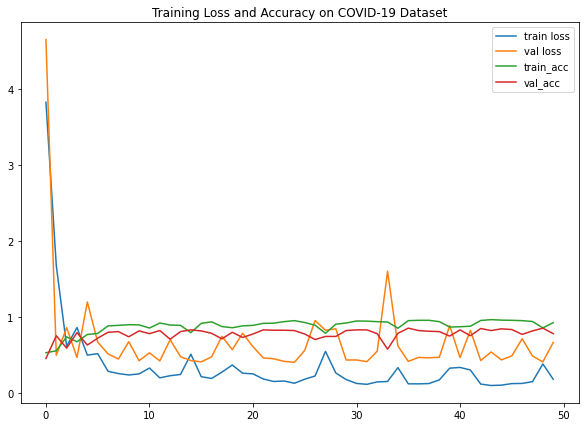

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(10,7))
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.legend()
plt.show()
plt.savefig('lossval_loss')

## Saving The H5 Format File

In [21]:
from tensorflow.keras.models import load_model

model.save('Covid Chest X-Ray Model.h5')

## Predicting Our Model

In [22]:
pred=model.predict(test_set)
pred

array([[1.41947148e-02, 9.85805333e-01],
       [8.55063200e-02, 9.14493740e-01],
       [5.38452715e-03, 9.94615495e-01],
       [7.76443921e-04, 9.99223590e-01],
       [2.20371649e-01, 7.79628396e-01],
       [1.68763218e-05, 9.99983072e-01],
       [1.84513061e-04, 9.99815524e-01],
       [1.29087925e-01, 8.70912135e-01],
       [9.99376833e-01, 6.23216329e-04],
       [9.95494485e-01, 4.50552627e-03],
       [7.74282664e-02, 9.22571719e-01],
       [1.54387534e-01, 8.45612526e-01],
       [9.99365866e-01, 6.34185271e-04],
       [9.51743364e-01, 4.82566543e-02],
       [9.99704540e-01, 2.95458653e-04],
       [9.99870300e-01, 1.29738313e-04],
       [9.99326706e-01, 6.73282542e-04],
       [9.92656231e-01, 7.34384498e-03],
       [9.92148101e-01, 7.85189401e-03],
       [3.33105636e-05, 9.99966741e-01],
       [9.97701466e-01, 2.29856791e-03],
       [8.40565562e-01, 1.59434468e-01],
       [9.81544137e-01, 1.84558239e-02],
       [3.55076604e-03, 9.96449232e-01],
       [9.974504

In [23]:
pred=np.argmax(pred,axis=1)
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1])

## Loading our Model

In [26]:
model=load_model('/content/Covid Chest X-Ray Model.h5')

In [28]:
from tensorflow.keras.preprocessing import image
img=image.load_img('/content/gdrive/My Drive/Colab Notebooks/Covid Chest X-ray/Data Set/Test/Covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg', target_size=(224,224))

In [29]:
x = image.img_to_array(img)
x

array([[[  0.,   0.,   0.],
        [  1.,   1.,   1.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  1.,   1.,   1.],
        [255., 255., 255.]],

       [[  1.,   1.,   1.],
        [  2.,   2.,   2.],
        [255., 255., 255.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [254., 254., 254.]],

       [[  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [255., 255., 255.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [255., 255., 255.]],

       ...,

       [[  0.,   0.,   0.],
        [  1.,   1.,   1.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [255., 255., 255.]],

       [[  0.,   0.,   0.],
        [  1.,   1.,   1.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [255., 255., 255.]],

       [[  0.,   0.,   0.],
        [  1.,   1.,   1.],
        [  0.,  

In [30]:
x.shape

(224, 224, 3)

In [31]:
x = x/255

In [32]:
from tensorflow.keras.applications.resnet50 import preprocess_input

x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [33]:
model.predict(img_data)

array([[1.000000e+00, 8.966153e-26]], dtype=float32)

In [34]:
a=np.argmax(model.predict(img_data), axis=1)

In [35]:
if(a==1):
    print("The person does not have COVID-19")
else:
    print("The person has COVID-19")

The person has COVID-19
